In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,),),                
           ])

train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

Необязательное задание. Обучить автокодировщик на изображениях с удаленной половиной.

In [4]:
def half_pixels(x):
    f = x    
    f[0,:,:14] = 0    
    return f
    
def half_batch(batch):
    batch_z = batch.clone().detach() 
    for i in range(batch_z.shape[0]):
        batch_z[i] = half_pixels(batch_z[i])
    return batch_z

In [5]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [6]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0., rho=0.05):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self.rho = rho
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        
        D_KL(P||Q)_optim = -p*log(p^) - (1-p)log(1-p^)
        """
        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
        dkl = - self.rho * torch.log(self.data_rho) - (1-self.rho)*torch.log(1-self.data_rho)
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(half_batch(data))
            rho_loss = model.rho_loss()
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [8]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(half_batch(data)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

Эксперимент с варьированием rho.

In [9]:
models = {'64-rho0.05': Net(latent_size=64, rho=0.05),
          '64-rho0.01': Net(latent_size=64, rho=0.01),
          '64-rho0.25': Net(latent_size=64, rho=0.25)}
#rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [10]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64-rho0.05: 0.986986 64-rho0.01: 1.032094 64-rho0.25: 0.994516
Train Epoch: 1 [10000/50000 (20%)]	Losses 64-rho0.05: 0.715348 64-rho0.01: 0.779640 64-rho0.25: 0.496466
Train Epoch: 1 [20000/50000 (40%)]	Losses 64-rho0.05: 0.458807 64-rho0.01: 0.539138 64-rho0.25: 0.345761
Train Epoch: 1 [30000/50000 (60%)]	Losses 64-rho0.05: 0.371742 64-rho0.01: 0.412962 64-rho0.25: 0.297301
Train Epoch: 1 [40000/50000 (80%)]	Losses 64-rho0.05: 0.347469 64-rho0.01: 0.378893 64-rho0.25: 0.284835
Train Epoch: 1 [50000/50000 (100%)]	Losses 64-rho0.05: 0.324592 64-rho0.01: 0.350516 64-rho0.25: 0.270370
Test set:
64-rho0.05: loss: 0.3131	rho_loss: 0.0059
64-rho0.01: loss: 0.3413	rho_loss: 0.0039
64-rho0.25: loss: 0.2576	rho_loss: 0.0116

Train Epoch: 2 [0/50000 (0%)]	Losses 64-rho0.05: 0.303248 64-rho0.01: 0.331935 64-rho0.25: 0.247217
Train Epoch: 2 [10000/50000 (20%)]	Losses 64-rho0.05: 0.300273 64-rho0.01: 0.324810 64-rho0.25: 0.249067
Train Epoch: 2 [20000/50000 (40%

Train Epoch: 11 [50000/50000 (100%)]	Losses 64-rho0.05: 0.118146 64-rho0.01: 0.133113 64-rho0.25: 0.100500
Test set:
64-rho0.05: loss: 0.1210	rho_loss: 0.0042
64-rho0.01: loss: 0.1364	rho_loss: 0.0018
64-rho0.25: loss: 0.1052	rho_loss: 0.0113

Train Epoch: 12 [0/50000 (0%)]	Losses 64-rho0.05: 0.122497 64-rho0.01: 0.139941 64-rho0.25: 0.107342
Train Epoch: 12 [10000/50000 (20%)]	Losses 64-rho0.05: 0.121367 64-rho0.01: 0.136743 64-rho0.25: 0.105792
Train Epoch: 12 [20000/50000 (40%)]	Losses 64-rho0.05: 0.122154 64-rho0.01: 0.133522 64-rho0.25: 0.103945
Train Epoch: 12 [30000/50000 (60%)]	Losses 64-rho0.05: 0.125258 64-rho0.01: 0.138615 64-rho0.25: 0.106326
Train Epoch: 12 [40000/50000 (80%)]	Losses 64-rho0.05: 0.128997 64-rho0.01: 0.142733 64-rho0.25: 0.111358
Train Epoch: 12 [50000/50000 (100%)]	Losses 64-rho0.05: 0.101870 64-rho0.01: 0.118748 64-rho0.25: 0.091033
Test set:
64-rho0.05: loss: 0.1182	rho_loss: 0.0042
64-rho0.01: loss: 0.1330	rho_loss: 0.0017
64-rho0.25: loss: 0.1027	rho_l

По изображениям складывается впечатление, что увеличение rho несколько улучшает качество восстановления. Кроме попытки декодировать единичную матрицу (dec_to_plot), здесь меньшее rho выглядит лучше.

In [19]:
data, _ = next(iter(test_loader))
data_z = half_batch(data)
output = models['64-rho0.01'](data_z)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64-rho0.01'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64-rho0.01'].E(data_z.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64-rho0.01'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([2, 1, 1, 2, 2, 1, 1, 1, 3, 1, 2, 1, 1, 3, 1, 2, 1, 3, 2, 1, 2, 2, 1, 1,
        1, 3, 2, 1, 2, 2, 2, 2, 4, 2, 1, 3, 0, 3, 0, 2, 3, 1, 2, 0, 2, 1, 2, 1,
        4, 1])


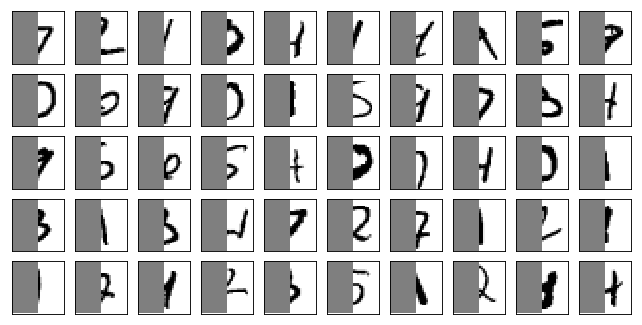

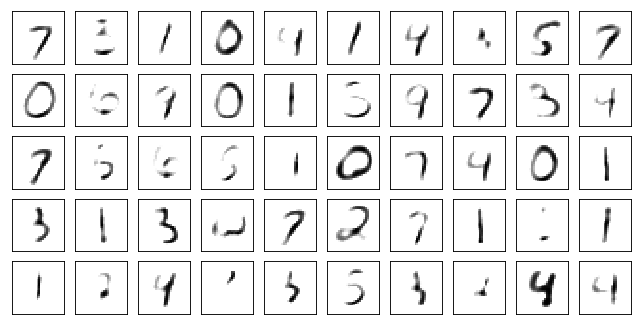

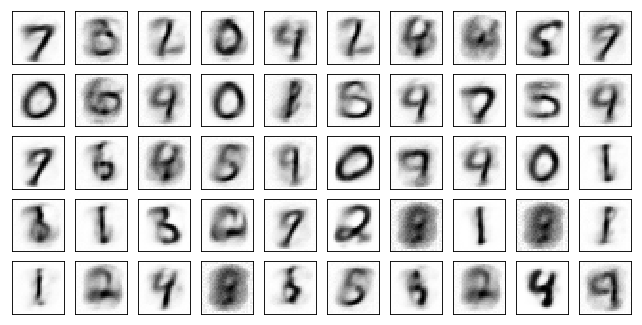

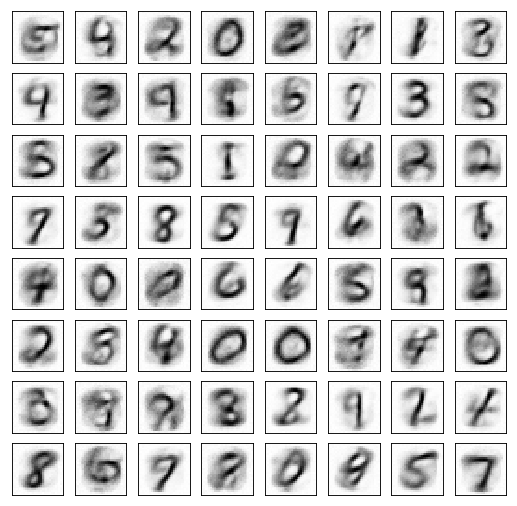

In [20]:
plot_mnist(data_z.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

In [21]:
data, _ = next(iter(test_loader))
data_z = half_batch(data)
output = models['64-rho0.05'](data_z)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64-rho0.05'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64-rho0.05'].E(data_z.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64-rho0.05'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([2, 3, 3, 2, 3, 2, 1, 4, 6, 2, 5, 2, 2, 4, 3, 2, 2, 4, 2, 3, 3, 4, 3, 2,
        2, 5, 4, 5, 4, 3, 2, 5, 3, 3, 1, 2, 2, 3, 0, 3, 3, 1, 1, 2, 2, 3, 3, 2,
        7, 2])


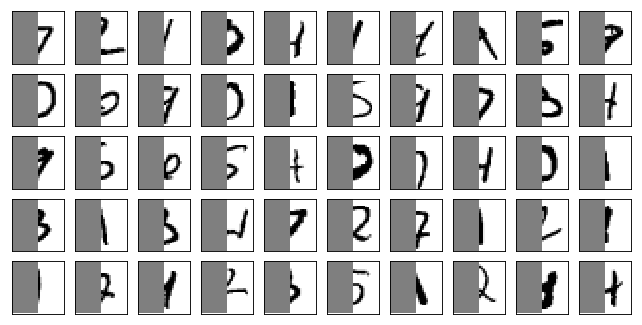

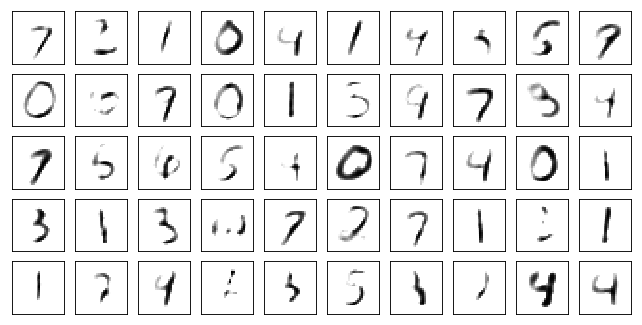

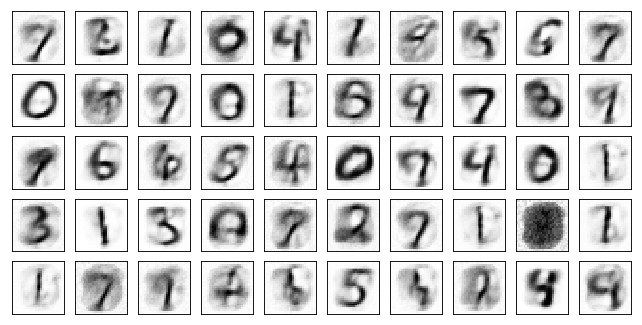

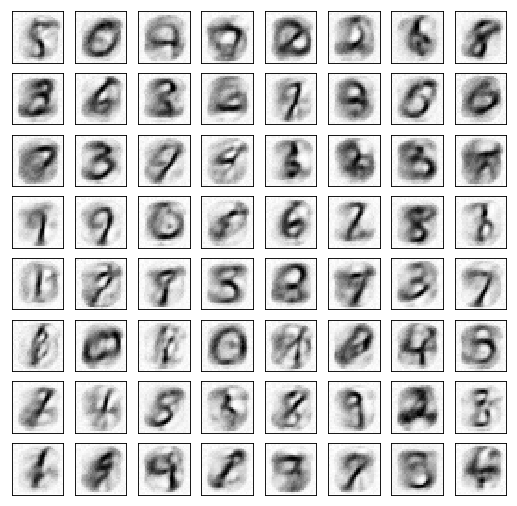

In [22]:
plot_mnist(data_z.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

In [23]:
data, _ = next(iter(test_loader))
data_z = half_batch(data)
output = models['64-rho0.25'](data_z)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64-rho0.25'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64-rho0.25'].E(data_z.view(-1, 28*28))
    print((encoded > 0.5).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models['64-rho0.25'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([12, 11,  8, 16, 12, 11,  8, 11, 14, 13, 15, 15, 11, 15, 13,  9, 15, 16,
        11, 11, 14, 11, 12, 12, 11, 16, 15, 12, 16, 16, 13, 11, 11,  6, 15, 10,
        11, 13, 13, 14, 14, 11,  7, 11, 13, 11, 13,  8, 15, 13])


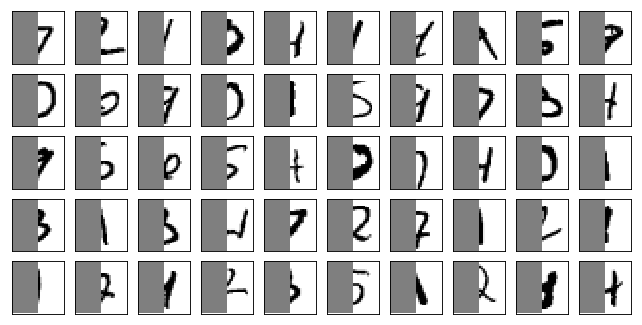

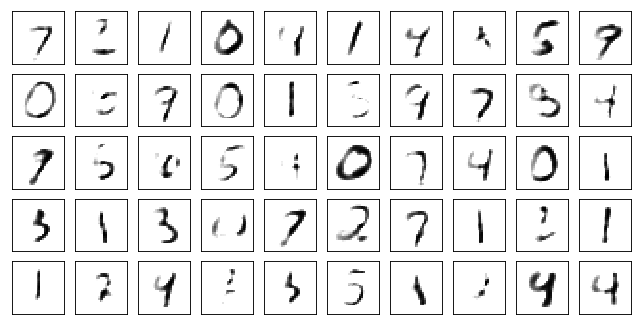

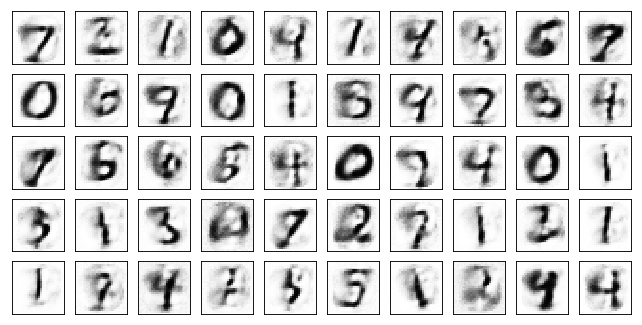

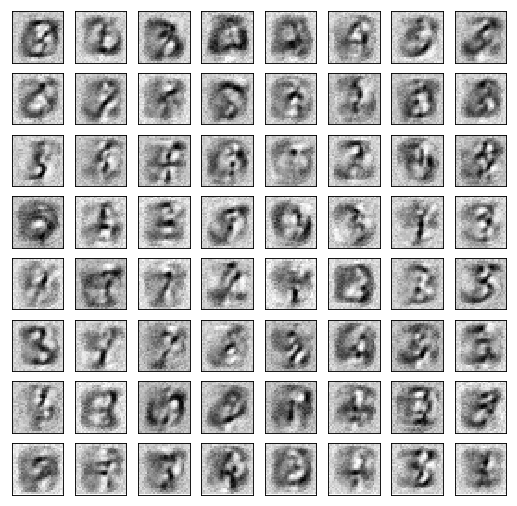

In [24]:
plot_mnist(data_z.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))